<a href="https://colab.research.google.com/github/rreghunandan/ML--Computer-Vision-/blob/main/ML_Computer_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip uninstall umap
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 4.5 MB/s 
     |████████████████████████████████| 1.1 MB 50.7 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=f6366139829f6d54d4f5ce5ad38d368b4c0e266c126c1c5bfca7ac26881e2030
  Stored in directory: /root/.cache/pip/wheels/a9/3a/67/06a8950e053725912e6a8c42c4a3a241410f6487b8402542ea
  Created wheel for pynndescent: filename=pynndescent-0.5.8-py3-none-any.whl size=55513 sha256=7dbfaa2b82bc7a6c07f9c704d20403f7d011e0fd7d6cfc78b0686bad2ce83216
  Stored in directory: /root/.cache/pip/wheels/1c/63/3a/29954bca1a27ba100ed8c27973a78cb71b43dc67aed62e80c3
Successfully built umap-learn pynndescent


In [2]:
import numpy as np
import pandas as pd
import cv2
import os
import umap

import torch 

#import swat
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
import matplotlib.pyplot as plt
from pathlib import Path
import glob

In [3]:
from collections import defaultdict
from PIL import Image


Reading data

In [4]:
img = '/content/drive/MyDrive/images'
df = '/content/gicsd_labels.csv'
data = pd.read_csv(df)

In [5]:
all_image_files = [ datum['IMAGE_FILENAME'] for index, datum in data.iterrows()]
all_image_labels = [datum[' LABEL'] for index, datum in data.iterrows()]


all_images = [cv2.imread(os.path.join(img,file)) for file in all_image_files]


In [6]:
image_shapes = [image.shape for image in all_images]   #chechking the shape of img
print(image_shapes)

[(192, 192, 3), (192, 192, 3), (192, 192, 3), (192, 192, 3), (192, 192, 3), (192, 192, 3), (192, 192, 3), (192, 192, 3), (192, 192, 3), (192, 192, 3), (192, 192, 3), (192, 192, 3), (192, 192, 3), (192, 192, 3), (192, 192, 3), (192, 192, 3), (192, 192, 3), (192, 192, 3), (192, 192, 3), (192, 192, 3), (192, 192, 3), (192, 192, 3), (192, 192, 3), (192, 192, 3), (192, 192, 3), (192, 192, 3), (192, 192, 3), (192, 192, 3), (192, 192, 3), (192, 192, 3), (192, 192, 3), (192, 192, 3), (192, 192, 3), (192, 192, 3), (192, 192, 3), (192, 192, 3), (192, 192, 3), (192, 192, 3), (192, 192, 3), (192, 192, 3), (192, 192, 3), (192, 192, 3), (192, 192, 3), (192, 192, 3), (192, 192, 3), (192, 192, 3), (192, 192, 3), (192, 192, 3), (192, 192, 3), (192, 192, 3), (192, 192, 3), (192, 192, 3), (192, 192, 3), (192, 192, 3), (192, 192, 3), (192, 192, 3), (192, 192, 3), (192, 192, 3), (192, 192, 3), (192, 192, 3), (192, 192, 3), (192, 192, 3), (192, 192, 3), (192, 192, 3), (192, 192, 3), (192, 192, 3), (192, 192

In [7]:
data_dict = defaultdict(list)
for index, datum in data.iterrows():
    data_dict[datum[' LABEL']].append(os.path.join(img, datum['IMAGE_FILENAME'])) 
for key, images in data_dict.items():
    print(key, len(images))


 FULL_VISIBILITY  646
 PARTIAL_VISIBILITY  123
 NO_VISIBILITY  31


The dataset is highly unballanced with 'NO_VISIBILITY' class having less images than the 'FULL_VISIBILITY'.
There are several ways to overcome the disbalance in the data classes:

1.Add more data.
2.Oversample with synthetic data
3.Undersample the more prevalent class

 FULL_VISIBILITY 


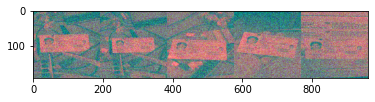

 PARTIAL_VISIBILITY 


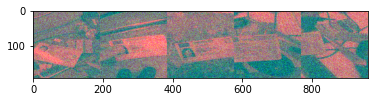

 NO_VISIBILITY 


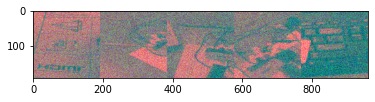

In [8]:
for key, images in data_dict.items():                                          #visualising the dataset
    frames = [cv2.imread(im) for im in images[:5]]
    print(key)
    plt.imshow(np.asarray(np.hstack(frames)))
    plt.show()

The images seems to be noisy and not colour balanced. To check that we can look at the colour histogram of few images



 FULL_VISIBILITY 


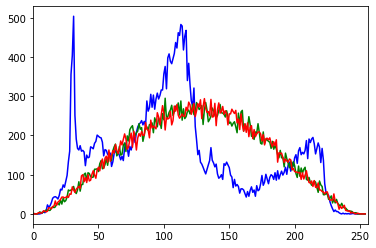

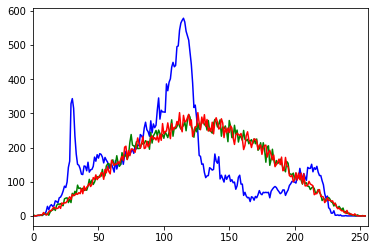

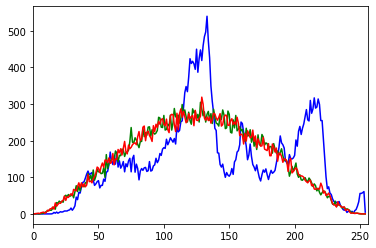

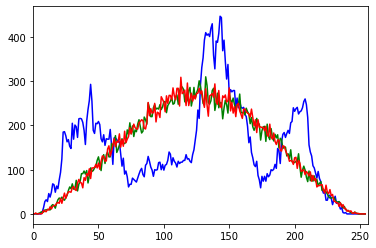

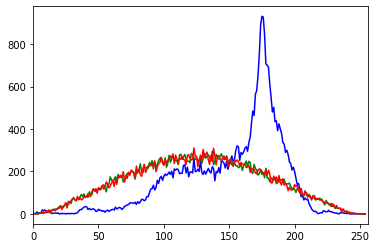

 PARTIAL_VISIBILITY 


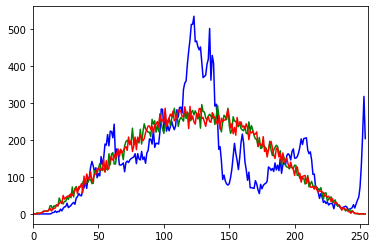

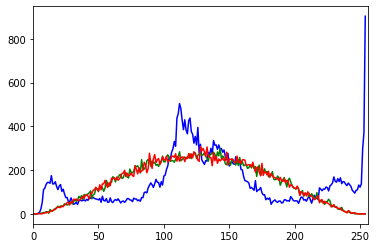

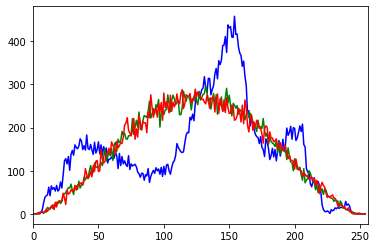

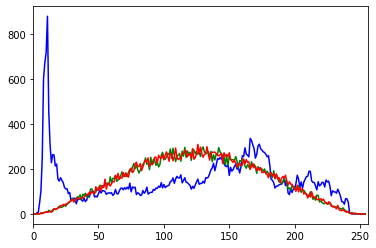

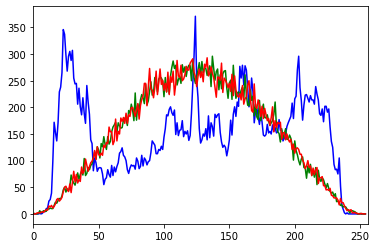

 NO_VISIBILITY 


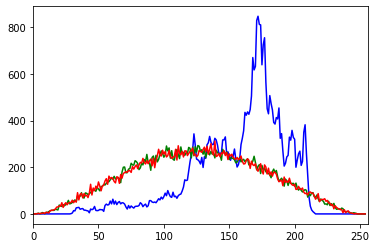

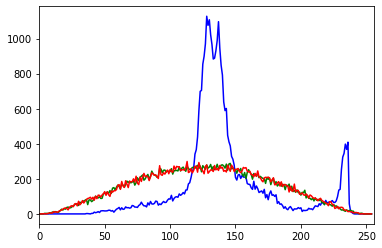

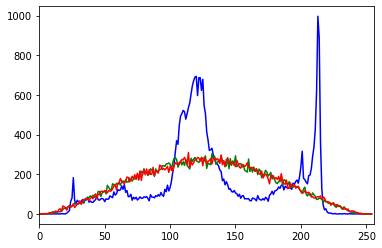

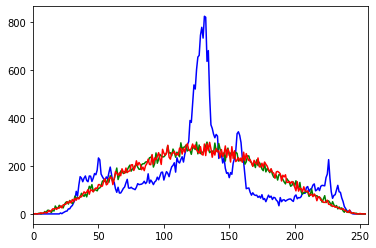

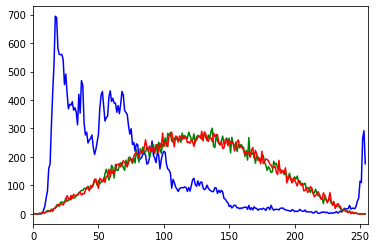

In [9]:
colours = ['b','g','r'] 

for key, images in data_dict.items():
    print(key)
    frames = [cv2.imread(im) for im in images[:5]]
    for frame in frames: 
        chans = cv2.split(frame)
        for (chan, color) in zip(chans, colours):   
            hist = cv2.calcHist([chan],[0], None, [255], [0, 256])
            plt.plot(hist, color = color)
            plt.xlim([0, 256])
        plt.show()

The colour histogram indicates that all the image information is stored in the blue channel (#0 in BGR), while channels green and red (1 and 2) only have Gaussian noise.


 FULL_VISIBILITY 


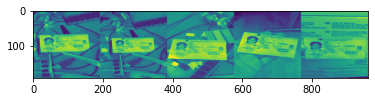

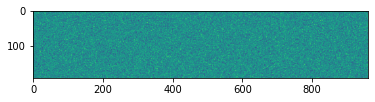

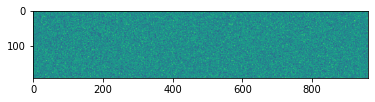

 PARTIAL_VISIBILITY 


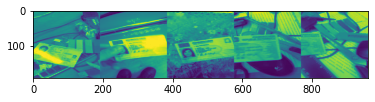

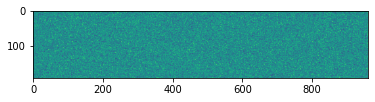

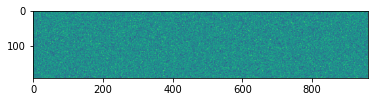

 NO_VISIBILITY 


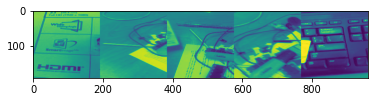

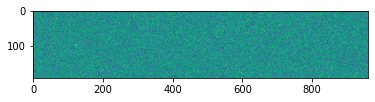

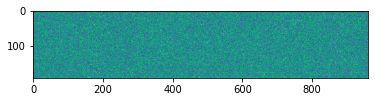

In [10]:
for key, images in data_dict.items():
    frames = [cv2.imread(im) for im in images[:5]]
    blues = [frame[:,:,0] for frame in frames]
    greens = [frame[:,:,1] for frame in frames]
    reds = [frame[:,:,2] for frame in frames]
    print(key)
    plt.imshow(np.asarray(np.hstack(blues)))
    plt.show()
    plt.imshow(np.asarray(np.hstack(greens)))
    plt.show()
    plt.imshow(np.asarray(np.hstack(reds)))
    plt.show()

In [11]:
new_root = 'data/images_grayscale'
os.makedirs(new_root, exist_ok=True)
all_images = [im[:,:] for im in all_images]
for im, filename in zip(all_images, all_image_files):
    cv2.imwrite(os.path.join(new_root, filename), im)

In [12]:
def grayscale_channel(img_path):
    img = cv2.imread(img_path) 
    return img[:,:,0]

In [13]:
all_image_files

['GICSD_1_0_3.png',
 'GICSD_1_0_13.png',
 'GICSD_1_1_33.png',
 'GICSD_1_1_53.png',
 'GICSD_1_2_73.png',
 'GICSD_1_3_93.png',
 'GICSD_1_3_113.png',
 'GICSD_1_4_133.png',
 'GICSD_1_5_153.png',
 'GICSD_1_5_173.png',
 'GICSD_1_6_193.png',
 'GICSD_1_7_213.png',
 'GICSD_1_7_233.png',
 'GICSD_1_8_253.png',
 'GICSD_1_9_273.png',
 'GICSD_1_9_293.png',
 'GICSD_2_0_3.png',
 'GICSD_2_0_13.png',
 'GICSD_2_1_33.png',
 'GICSD_2_1_53.png',
 'GICSD_2_2_73.png',
 'GICSD_2_3_93.png',
 'GICSD_2_3_113.png',
 'GICSD_2_4_133.png',
 'GICSD_2_5_153.png',
 'GICSD_2_5_173.png',
 'GICSD_2_6_193.png',
 'GICSD_2_7_213.png',
 'GICSD_2_7_233.png',
 'GICSD_2_8_253.png',
 'GICSD_2_9_273.png',
 'GICSD_2_9_293.png',
 'GICSD_3_0_3.png',
 'GICSD_3_0_13.png',
 'GICSD_3_1_33.png',
 'GICSD_3_1_53.png',
 'GICSD_3_2_73.png',
 'GICSD_3_3_93.png',
 'GICSD_3_3_113.png',
 'GICSD_3_4_133.png',
 'GICSD_3_5_153.png',
 'GICSD_3_5_173.png',
 'GICSD_3_6_193.png',
 'GICSD_3_7_213.png',
 'GICSD_3_7_233.png',
 'GICSD_3_8_253.png',
 'GICSD_3

In [14]:
data

,IMAGE_FILENAME,LABEL
0,GICSD_1_0_3.png,FULL_VISIBILITY
1,GICSD_1_0_13.png,FULL_VISIBILITY
2,GICSD_1_1_33.png,PARTIAL_VISIBILITY
3,GICSD_1_1_53.png,FULL_VISIBILITY
4,GICSD_1_2_73.png,FULL_VISIBILITY
...,...,...
795,GICSD_50_7_213.png,NO_VISIBILITY
796,GICSD_50_7_233.png,PARTIAL_VISIBILITY
797,GICSD_50_8_253.png,FULL_VISIBILITY
798,GICSD_50_9_273.png,FULL_VISIBILITY


In [15]:
# Split dataframe by label and shuffle it
data_fv= data[data[' LABEL']==' FULL_VISIBILITY '].reset_index(drop=True)
data_pv= data[data[" LABEL"]==' PARTIAL_VISIBILITY '].reset_index(drop=True)
data_nc= data[data[" LABEL"]==' NO_VISIBILITY '].reset_index(drop=True)

test = data_fv.loc[:int(len(data_fv)*.1),:]
test = test.append(data_pv.loc[:int(len(data_pv)*.1),:], ignore_index=True)
test = test.append(data_nc.loc[:9,:], ignore_index=True)
test.to_csv('data/gicsd_labels_test.csv')

data_fv = data_fv.loc[int(len(data_fv)*.1)+1:,:]
data_pv = data_pv.loc[int(len(data_pv)*.1)+1:,:]
data_nc = data_nc.loc[10:,:]

print(test.shape)
print(data_fv.shape)
print(data_pv.shape)
print(data_nc.shape)

(88, 2)
(581, 2)
(110, 2)
(21, 2)


In [16]:
data_pv

,IMAGE_FILENAME,LABEL
13,GICSD_7_6_193.png,PARTIAL_VISIBILITY
14,GICSD_7_7_213.png,PARTIAL_VISIBILITY
15,GICSD_8_3_93.png,PARTIAL_VISIBILITY
16,GICSD_8_5_173.png,PARTIAL_VISIBILITY
17,GICSD_8_6_193.png,PARTIAL_VISIBILITY
...,...,...
118,GICSD_49_1_53.png,PARTIAL_VISIBILITY
119,GICSD_49_6_193.png,PARTIAL_VISIBILITY
120,GICSD_50_2_73.png,PARTIAL_VISIBILITY
121,GICSD_50_6_193.png,PARTIAL_VISIBILITY


Augment data to avoid overfitting and underfitting

In order to balance the classes in the training dataset  oversample the less prevalent classes is done. Since the original dataset consists of images of the same id card taken with different angles and with different rotations I have chosen to rotate images  to the PARTIAL_VISIBILITY and NO_VISIBILITY classes in order to increase the number of examples on these classes. In addition for NO_VISIBILITY class we will add horisontal and vertical flip.


In [26]:
! pip install utils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [30]:
from keras.utils import to_categorical


In [37]:
root = 'data/images_grayscale'
from keras.utils import *
from utils import *



In [39]:
data_nc = rotate_data(data_nc, root)


print(data_nc.shape)

NameError: ignored